## AB-test

In [1]:
import pandas as pd
import pandahouse as ph
from scipy import stats
import hashlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
connection = {'host' : 'https://clickhouse.lab.karpov.courses',
              'database' : 'simulator_20220820',
              'user' : 'student',
              'password' : 'dpo_python_2020'
             }

query = '''
    SELECT user_id,
           countIf(user_id, action = 'like' ) as like,
           countIf(user_id, action = 'view' ) as view,
           like/view as CTR,
           exp_group
      FROM {db}.feed_actions
      WHERE toDate(time) >= '2022-07-13' and toDate(time) <= '2022-07-19'
      GROUP BY user_id, exp_group
      '''

df = ph.read_clickhouse(query, connection = connection)

Пришло время проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов. Эксперимент проходил с **2022-07-13 по 2022-07-19** включительно. Для эксперимента были задействованы 2 и 1 группы. 

В **группе 2** был использован один из новых алгоритмов рекомендации постов, **группа 1** использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

Ваша задача — проанализировать данные АB-теста. 

- Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).
- Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали так как сработали? 
- Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.
- Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.

#### Выбор метода анализа и сравнение CTR

Посмотрим, что представляют из себя наши экспериментальные группы.

In [3]:
df_g = df.query('exp_group == 1 | exp_group == 2')

In [12]:
df_g

,user_id,like,view,CTR,exp_group
1,18392,7,32,0.218750,1
3,131473,14,134,0.104478,2
5,32420,26,128,0.203125,2
6,24239,40,90,0.444444,2
8,27443,2,29,0.068966,1
...,...,...,...,...,...
50138,21697,2,22,0.090909,1
50140,1232,5,96,0.052083,2
50142,120653,15,74,0.202703,1
50146,132567,45,296,0.152027,1


In [4]:
df_g.groupby('exp_group')['CTR'].agg(['mean', 'median', 'count', 'sum'])

,mean,median,count,sum
exp_group,,,,
1,0.215605,0.203125,10079,2173.078747
2,0.214419,0.142857,9952,2133.900610


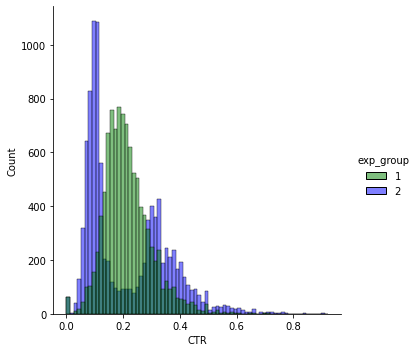

In [6]:
sns.displot(x='CTR',
            hue ='exp_group',
            data=df_g,
            palette = ['g', 'b']);

Построим "ящики с усами", чтобы предварительно оценить нормальность распределения, размах выборок, вариативность данных, выбросы и медианные значения.

<AxesSubplot:xlabel='exp_group', ylabel='CTR'>

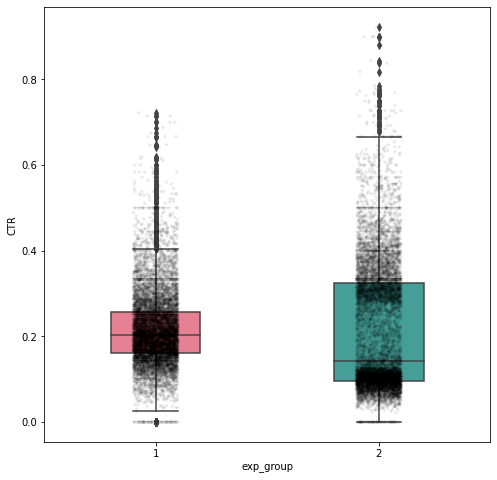

In [7]:
fig = plt.subplots(1,1, figsize=(8, 8))

sns.boxplot(data = df_g,
            x = 'exp_group',
            y = 'CTR',
            palette = 'husl',
            width=0.4)
sns.stripplot(data = df_g, 
                        x= "exp_group",
                        y = "CTR",
                        marker="*",
                        alpha=0.1,
                        color="black")

Из графиков видно, что визуально распределения отличаются друг от друга: контрольная группа 1 имеет распределение более-менее напоминающее нормальное, в то время как экспериментальная группа - распределение с двумя пиками. Безусловно более точный ответ нам дадут графики Q-Q plot и критерий Шапиро-Уилка. Касаемо медианных значений, то видно, что в контрольной группе они имеют более высокие значения. Обращает на себя внимание значительный размах экспериментальный группы с двумя явно выраженными пиками в районе 0.07-0.12 и 0.28-0.33. Причем значений в первом диапазоне в разы больше, чем во втором.

Отметим, что средние значения групп совпадают, а разница наблюдается в медианах. Вероятнее, всего t-test нам ничего вразумительного не покажет.

#### Сглаживание CTR

Проведем сглаживание CTR, нивелировав "вклад" пользователей с небольшим количеством просмотров, за счет штрафов.

In [8]:
def get_smoothed_ctr(user_likes, user_views, global_ctr, alpha):
    """
    Функция принимает на вход CTR каждого пользователя и возвращает сглаженный CTR
    --------------------
    Параметры:
    user_likes - лайки пользователя
    user_views - просмотры пользователя
    global_ctr - like/view для всех пользователей
    alpha - коэффициент сглаживания

    Функция возвращает: 
    smoothed_ctr - значение сглаженного CTR
    """
    smoothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smoothed_ctr

In [9]:
global_ctr_1 = df_g[df_g.exp_group == 1].like.sum()/df_g[df_g.exp_group == 1].view.sum()
global_ctr_2 = df_g[df_g.exp_group == 2].like.sum()/df_g[df_g.exp_group == 2].view.sum()
gr_sm_1 = df_g[df_g.exp_group == 1].copy()
gr_sm_2 = df_g[df_g.exp_group == 2].copy()

In [10]:
gr_sm_1['smoothed_ctr'] = df_g.apply(
                        lambda x: get_smoothed_ctr(x['like'], x['view'], global_ctr_1, 5), axis=1)
gr_sm_2['smoothed_ctr'] = df_g.apply(
                        lambda x: get_smoothed_ctr(x['like'], x['view'], global_ctr_2, 5), axis=1)

/nfs/env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='CTR'>

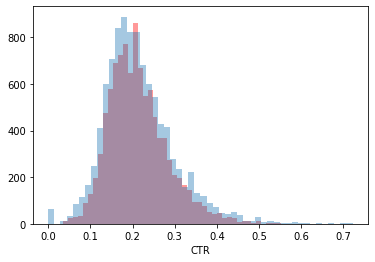

In [11]:
sns.distplot(gr_sm_1.smoothed_ctr,
             kde = False,
             color = 'r')
sns.distplot(gr_sm_1.CTR,
             kde = False)

In [12]:
gr_sm_1[{'smoothed_ctr', 'CTR'}].agg(['mean', 'median', 'count'])

,smoothed_ctr,CTR
mean,0.214025,0.215605
median,0.203480,0.203125
count,10079.000000,10079.000000


/nfs/env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='CTR'>

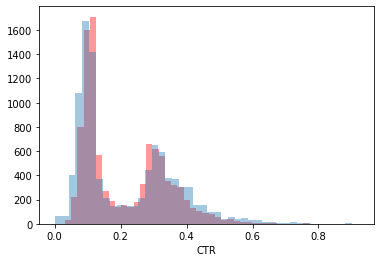

In [13]:
sns.distplot(gr_sm_2.smoothed_ctr,
             kde = False,
             color = 'r')
sns.distplot(gr_sm_2.CTR,
             kde = False)

In [14]:
gr_sm_2[{'smoothed_ctr', 'CTR'}].agg(['mean', 'median', 'count'])

,smoothed_ctr,CTR
mean,0.210740,0.214419
median,0.147879,0.142857
count,9952.000000,9952.000000


### Применение различных методов анализа

Итак, нашей гипотезой является, что новый алгоритм во 2-й группе приведет к увеличению CTR по сравнению с контрольной группой 1.

**Н0:** CTR экспериметальной и CTR контрольной групп не различаются. 

**H1:** Различия в CTR есть.

α = 0.05

In [15]:
# Разобьем группы по переменным для удобства
ex_gr_1 = df_g.query('exp_group == 1')['CTR']
ex_gr_2 = df_g.query('exp_group == 2')['CTR']

#### t-test

In [16]:
stats.ttest_ind(ex_gr_1, ex_gr_2, equal_var = False)

Ttest_indResult(statistic=0.7094392041270485, pvalue=0.4780623130874935)

Тест Стьюдента на обычном CTR выдал интересные результаты, показав, что средние наших групп равны: отбросить Н0 нельзя, т.к. p_value > α. Это неудивительно, т.к. результаты теста зависят от средних значений выборки, на которые в свою очередь большое влияние оказывают выбросы. В нашем случае получается, что пики экспериментальных групп друг друга "схлопывают", что приводит к практически равным средним с контрольной группой.

In [17]:
stats.ttest_ind(gr_sm_1['smoothed_ctr'], gr_sm_2['smoothed_ctr'], equal_var = False)

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

На сглаженном CTR результат больше похож на правду: статистика нашла различия p_value = 0.022 < α

#### Mann-Whitney U test

Данный критерий отличается от Стьюдента тем, что в основе его лежит присвоение значениям выборок определенных рангов. Дальше эти ранги суммируются внутри каждой выборки, и мы смотрим на полученную разность. Ранги позволяют снизить "веса" выбросов, который влияли на t-test.

**Н0:** Суммы рангов выборок равны.

**H1:** Суммы рангов не равны.

In [18]:
stats.mannwhitneyu(ex_gr_1, ex_gr_2, alternative = 'two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

In [19]:
stats.mannwhitneyu(gr_sm_1['smoothed_ctr'], gr_sm_2['smoothed_ctr'], alternative = 'two-sided')

MannwhitneyuResult(statistic=56925125.0, pvalue=1.6163964114270227e-61)

Тест Манна-Уитни выдает нам однозначные результаты как на обычном, так и на сглаженном CTR: p_value < α, а значит между нашими группами есть статистически значимые различия.

#### Бакетное преобразование

Раскидаем без повторений наших пользователей по корзинкам и проведем поверх них t-test и тест Манна-Уитни. Бакетизация позволяет нам нормализовать наши данные

In [20]:
q = """
    SELECT exp_group,
           bucket,
           sum(likes)/sum(views) as bucket_ctr,
           quantileExact(0.9)(ctr) as ctr9
      FROM (
           SELECT exp_group,
                  xxHash64(user_id)%50 as bucket,
                  user_id,
                  sum(action = 'like') as likes,
                  sum(action = 'view') as views,
                  likes/views as ctr
            FROM {db}.feed_actions
           WHERE toDate(time) between '2022-07-13' and '2022-07-19'
             AND exp_group in (1,2)
           GROUP BY exp_group, bucket, user_id)
     GROUP BY exp_group, bucket
"""
df = ph.read_clickhouse(q, connection=connection)

In [21]:
stats.ttest_ind(df[df.exp_group == 1].bucket_ctr, df[df.exp_group == 2].bucket_ctr, equal_var = False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

In [22]:
stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr, df[df.exp_group == 2].bucket_ctr, alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

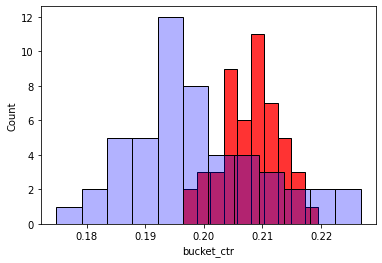

In [23]:
sns.histplot(df[df.exp_group == 1].bucket_ctr, bins = 10, color = 'r', alpha = 0.8)
sns.histplot(df[df.exp_group == 2].bucket_ctr, bins = 12, color = 'b', alpha = 0.3)

Тест Манна-Уитни и Тест Стьюдента поверх бакетного преобразования также склоняются на сторону альтернативной гипотезы, отклоняя нулевую. Да и гистограмма наглядно демонстрирует разницу между нашими группами. Причем опять мы фиксируем, что показатели CTR у экспериментальной группы ниже, чем у контрольной.

#### Бутстреп

Впервые увидев боксплот и агрегированные суммы CTR по группам, закралось предположение, что несмотря на то, что экспериментальная группа, скорее всего, отличается от контрольной, эффективность нововведений весьма сомнительна. Да, у второй группы есть второй пик, который превышает медиану первой группы. Но данный пик не такой уж и высокий. Большая часть CTR у экспериментальный группы все-таки значительно ниже медианы первой группы. А средние показатели кое-как выравниваются за счет второго пика. В общем, давайте превратим нашу выборку в условную "генеральную совокупность", искусственно создав из нее множество подвыборок.

In [24]:
def boot_CTR(df, exp_group, n_exp = 5000):
    """
    Функция boot_CTR создает псевдовыборку методом bootstrap
    --------------------
    Параметры:
    df - дата-фрейм
    exp_group - номер группы
    n_exp - число экспериментов

    Функция возвращает: 
    pd.Series(CTR_list) - Series CTR
    """
        
    CTR_list = []
    for i in range(n_exp):
        ex_samp = df[df.exp_group == exp_group].sample(replace = True)
        ex_samp_CTR = ex_samp.like.sum()/ex_samp.view.sum()
        CTR_list.append(ex_samp_CTR)
    return pd.Series(CTR_list)

In [25]:
ex_samp_1 = boot_CTR(df_g, 1)
ex_samp_2 = boot_CTR(df_g, 2)

<AxesSubplot:ylabel='Count'>

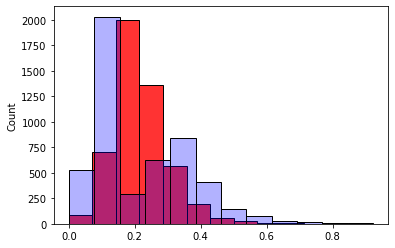

In [26]:
sns.histplot(ex_samp_1, bins = 10, color = 'r', alpha = 0.8)
sns.histplot(ex_samp_2, bins = 12, color = 'b', alpha = 0.3)

In [39]:
stats.ttest_ind(ex_samp_1, ex_samp_2, equal_var = False)

Ttest_indResult(statistic=1.8833753690051405, pvalue=0.059684816458961426)

In [40]:
stats.mannwhitneyu(ex_samp_1, ex_samp_2, alternative = 'two-sided')

MannwhitneyuResult(statistic=14235875.0, pvalue=2.593193912712084e-33)

Аналогичная картина той, что мы наблюдали, когда применяли данные статистические критерии на "обычной" выборке: Тест Стьюдента ничего не нашел (хотя значение p_value существенно снизилось; увеличив количество экпериментов оно снизится еще больше), а Манн-Уитни говорит, что нулевую гипотезу надо отклонять.

#### Рекомендации

- Подтвердилась гипотеза, что новый алгоритм влияет на поведение пользователей.
- Среднее CTR экспериментальной группы практически совпадает с контрольной. Медианы существенно различаются (1 гр. - 0.203, 2 гр. - 0.142).

Примененный алгоритм явно разбил пользователей экспериментальной группы на 2 части: у первой части CTR существенно упал, а у второй существенно вырос. Прежде чем "раскатывать" или не раскатывать алгоритм необходимо провести дополнительное исследование с целью выявить, кто выходит во вторую часть экспериментальной группы, у которой существенно вырос CTR (0.28-0.33). Возможно, стоит посмотреть на CTR в разрезе половозрастной структуры или ОС (смотреть страну, наверное, большого смысла нет, т.к. большая часть пользователей из России).